Mass-Spring-Damper Model Estimation
-----------------------------------

### System Description

This is a really simple model: A 1-DOF mass-spring-damper system.

In [1]:
from IPython.display import Image

Image(url='https://github.com/stuckeyr/msd/raw/master/mass_spring_damper.png')

See [here](http://ctms.engin.umich.edu/CTMS/index.php?example=Introduction&section=SystemModeling#5) for a more detailed explanation.

The equations of motion can be written:

$$
\sum F_x = F(t) - b \dot{x} - kx = m \ddot{x}
$$

where $x$ is the displacement, $m$ is the mass, $k$ is the spring constant, $b$ is the damping constant and $F$ is the input force, expressed here as a function of time.

Reframing the system in state-space form, using the state vector:

$$
\mathbf{x} = \begin{bmatrix} x \\\ \dot{x} \end{bmatrix}
$$

the equations are written:

$$
m \mathbf{\dot{x}} = \begin{bmatrix} \dot{x} \\\ \ddot{x} \end{bmatrix} = \begin{bmatrix} 0 & m \\\ -k & -b \end{bmatrix} \begin{bmatrix} x \\\ \dot{x} \end{bmatrix} + \begin{bmatrix} 0 \\\ 1 \end{bmatrix} F(t)
$$

### Simulation in Python 

First, reset the workspace. Import all necessary libraries (the following assumes you have built both Boost and Cython models).

In [2]:
%matplotlib notebook

In [3]:
%reset -f

In [4]:
import numpy as np
import numpy.matlib as ml
from scipy import interpolate, integrate

Create the model. Below is the pure Python version, which I have included for information.

In [5]:
# ------------------------------------------------------------------------------
# MSD class
# ------------------------------------------------------------------------------
class MSD(object):
    """
    The MSD class represents a Mass-Spring-Damper system.
    """
    # System parameters
    m = 30.48

    def __init__(self, name, **kwargs):
        """
        Initialise the msd object.

        :param: name  = system name
        """
        self.name = name

        # Pass through any other keyword arguments
        for key in kwargs:
            self.__dict__[key] = kwargs[key]

        self.c_idx = [ 'k', 'b', 'd' ]

        # Model coefficients
        self.C = { 'k': -50.0, 'b': -10.0, 'd': 1.0, 'z': 0.0 }

        # External force function
        self.d_func = None

        # State noise function
        self.w_func = None

        self.init()

    def __str__(self):
        return self.name

    def init(self):
        """
        Construct the force and moment matrices.
        """
        # Rigid body mass matrix
        self.C_M_I = 1.0/self.m

        self.C_SD = ml.zeros((2, 2))
        self.M_EF = ml.zeros((2, 1))

    def get_coeffs(self):
        """
        Get the model coefficients.
        """
        return self.C

    def set_coeffs(self, C):
        """
        Set the model coefficients.
        """
        for ck in C.keys():
            self.C[ck] = C[ck]

    def set_external_forces(self, T_S, D_S, interp_kind):
        """
        Set the external force interpolant points.
        """
        self.d_func = interpolate.interp1d(T_S, D_S, kind=interp_kind, axis=0, bounds_error=False)

    def add_state_noise(self, T_S, W_S):
        """
        Set the state noise interpolant points.
        """
        self.w_func = interpolate.interp1d(T_S, W_S, kind='linear', axis=0, bounds_error=False)

    def rates(self, x, t):
        """
        Calculate the system state-rate for the current state x.

        :param: x = current system state [ xp, xpd ]
        :param: t = current time

        :returns: xdot = system state-rate
        """
        # Spring-damper forces
        # C_SD = np.mat([[    0.0,      self.m     ],
        #                [ self.C['k'], self.C['b']]])
        self.C_SD[0, 0] = 0.0
        self.C_SD[0, 1] = self.m
        self.C_SD[1, 0] = self.C['k']
        self.C_SD[1, 1] = self.C['b']

        M_SD = self.C_SD*x.reshape((-1, 1))

        d = np.nan_to_num(self.d_func(t))

        # External force
        # M_EF = np.mat([[           0.0 ],
        #                [ self.C['d']*f ]])
        self.M_EF[0, 0] = 0.0
        self.M_EF[1, 0] = self.C['d']*d

        xdot = np.ravel(self.C_M_I*(M_SD + self.M_EF))

        if (self.w_func is not None):
            xdot[1] += np.nan_to_num(self.w_func(t))

        return xdot

    def rrates(self, t, x):
        """
        Rates method with arguments reversed.
        """
        return self.rates(x, t, self.d_func)

    def forces(self, xdot, x):
        """
        Calculate the forces from recorded state data.

        :param: xdot = system state rate
        :param: x = system state [ xp, xpd ]

        :returns: f = state forces
        """
        xpddot = xdot[1]

        f = self.m*xpddot

        return f

    def integrate(self, x0, T):
        """
        Integrate the differential equations and calculate the resulting rates and forces.

        :param: x0 = initial system state
        :param: T = sequence of time points for which to solve for x

        :returns: X = system state array
        :returns: Xdot = state rates array
        :returns: F = state force array
        """
        N = T.shape[0]

        # Initialise the model
        self.init()

        # Perform the integration
        X = integrate.odeint(self.rates, x0, T, rtol=1.0e-6, atol=1.0e-6)

        Xdot = np.zeros((N, len(x0)))
        for n in range(N):
            Xdot[n] = self.rates(X[n], T[n])

        # Force and moment matrix
        F = np.zeros((N, 1))
        for n in range(N):
            F[n] = self.forces(Xdot[n], X[n])

        return X, Xdot, F

But we are going to use the Cython implementation here, as the Python model is very slow!. Simulate and add (Gaussian) noise to the output.

In [6]:
from msd import MSD_BOOST
from msdc import MSD_CYTHON

In [7]:
# Measurement and state noise standard deviations
NOISE_SD = [ 0.001 for _ in range(3) ]
STATE_NOISE_SD = 0.0

VERBOSE = False

# Simulation model
MODEL = 'cython' # ['python', 'cython', 'boost']

# Zero the RNG seed
np.random.seed(1)

# Initial system state and external force input
x0 = np.zeros((2, ))
d0 = 0.0

# Sample period
dt = 0.01

# Start and end time
t0 = 0.0
tN = 15.0

# Create the time vector
T = np.arange(t0, tN, dt)
N = T.shape[0]

# Create the predefined external force vector
T_S0 = np.hstack((t0, np.arange(t0 + 1.0, tN + 1.0, 1.0), tN))
D_S0 = np.hstack((d0, np.array([ d0 + ((_ % 2)*2 - 1) * 1.0 for _ in range(T_S0.shape[0] - 2) ]), d0))
interpfun = interpolate.interp1d(T_S0, D_S0, kind='zero', axis=0, bounds_error=False)
D0 = np.array([ [ interpfun(t) ] for t in T ])
T_S = T_S0.copy()
D_S = D_S0.copy()
D = D0.copy()

# Create the simulation model
if (MODEL == 'boost'):
    # Boost extension
    msd = MSD_BOOST("Mass-Spring-Damper (Boost)", N)
    msd.set_external_forces(T_S, D_S, 'zero')
elif (MODEL == 'cython'):
    # Cython
    msd = MSD_CYTHON("Mass-Spring-Damper (Cython)")
    msd.set_external_forces(T_S, D_S, 'zero')
else:
    # Pure Python
    msd = MSD("Mass-Spring-Damper (Python)")
    msd.set_external_forces(T_S, D_S, 'zero')

# Identification keys
c_idx = ['k', 'b', 'd']

# True parameter set
CT = [ msd.get_coeffs()[ck] for ck in c_idx ]

# Initial parameter set
C0 = [ 0.5*msd.get_coeffs()[ck] for ck in c_idx ]

# Add any state noise
if (STATE_NOISE_SD > 0.0):
    sdw = STATE_NOISE_SD
    W = np.random.randn(N, 1)*sdw
    msd.add_state_noise(T, W)

# Compute the response
X, Xdot, F = msd.integrate(x0, T)

# State noise standard deviation vector
sdz = np.zeros((len(x0),))
if any(w > 0.0 for w in NOISE_SD[:2]):
    sdz = np.array(NOISE_SD[:2])

# Measured state matrix
Z = X + np.random.randn(N, len(x0))*sdz

# Set the initial measured state equal to the initial true state
z0 = x0

Nu = Z[:,1]
sdnu = sdz[1]

# State rate noise standard deviation vector
sdzdot = np.zeros((len(x0),))
if any(w > 0.0 for w in NOISE_SD[:2]):
    sdzdot = np.array(NOISE_SD[:2])

# Measured state rate matrix
Zdot = Xdot + np.random.randn(N, len(x0))*sdzdot

# External force noise standard deviation vector
sde = 0.0
if (NOISE_SD[2] > 0.0):
    sde = NOISE_SD[2]

# Measured external force matrix
E = D + np.random.randn(N, 1)*sde

# Set the initial measured external force equal to the initial true external force
e0 = d0

# Compute the inertial force and noise standard deviation
G = F.copy()
sdg = 0.0
if any(w > 0.0 for w in NOISE_SD):
    # Forces are calculated from (measured) accelerations, not measured directly
    for n in range(N):
        G[n] = msd.forces(Zdot[n], Z[n])
    sdg = np.std(F - G)

Plot the measured response and control input.

In [8]:
import matplotlib.pyplot as pp

<IPython.core.display.Javascript object>


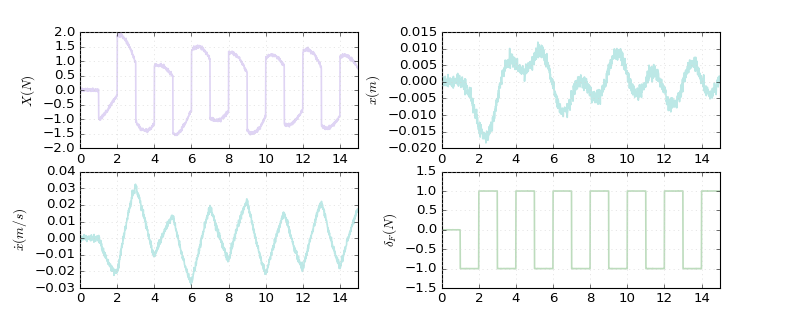

In [9]:
x_str = [ r'$x (m)$', r'$\dot x (m/s)$' ]
x_fac = [ 1.0, 1.0 ]
d_str = [ r'$\delta_F (N)$' ]
d_fac = [ 1.0 ]
f_str = [ r'$X (N)$' ]
f_fac = [ 1.0 ]
ff_str = [ r'ln ${\Delta X}^2 (N^2)$' ]

nc = 2 # number of columns
nr = 2 # number of rows

fig, AxesArr = pp.subplots(nr, nc, figsize=(10.0, 4.0))

Axes = np.ravel(AxesArr)

ax = Axes[0]
ax.grid(color='lightgrey', linestyle=':')
ax.plot(T, G*f_fac[0], color='#DFD4F4', linestyle='-', linewidth=1.5)
ax.set_xlim(T[0], T[N - 1])
ax.autoscale(enable=False)
ax.set_ylabel(f_str[0])

for j in range(2):
    ax = Axes[j + 1]
    ax.grid(color='lightgrey', linestyle=':')
    ax.plot(T, Z[:,j]*x_fac[j], color='#BCE8E6', linestyle='-', linewidth=1.5)
    ax.set_xlim(T[0], T[N - 1])
    ax.autoscale(enable=False)
    ax.set_ylabel(x_str[j])

ax = Axes[3]
ax.grid(color='lightgrey', linestyle=':')
ax.plot(T, E*d_fac[0], color='#BDDCBD', linestyle='-', linewidth=1.5)
ax.set_xlim(T[0], T[N - 1])
ax.autoscale(enable=False)
ax.set_ylabel(d_str[0])

pp.subplots_adjust(left=0.1, wspace=0.3)

### Least-Squares Estimation

Perform a Least-Squares estimation on the measured system.

In [10]:
from scipy import linalg, stats

In [11]:
FF = ml.repmat(None, 50, 1)

print "LINEAR REGRESSION:"

if (MODEL == 'boost'):
    # Create the model (Boost extension)
    msd_est = MSD_BOOST("Mass-Spring-Damper_FMIN_EST (Boost)", N)
    msd_est.set_external_forces(T, E, 'linear_uniform')
elif (MODEL == 'cython'):
    # Create the model (Boost extension)
    msd_est = MSD_CYTHON("Mass-Spring-Damper_FMIN_EST (Cython)")
    msd_est.set_external_forces(T, E, 'linear_uniform')
else:
    # Create the model (pure Python)
    msd_est = MSD("Mass-Spring-Damper_FMIN_EST")
    msd_est.set_external_forces(T, E, 'linear')

A = np.c_[Z[:,0],Zdot[:,0],E[:,0]]

# Least squares solution
C, resid, rank, sigma = linalg.lstsq(A, G)

sigma2 = np.sum((G - np.dot(A, C))**2.0)/(N - len(c_idx)) # RMSE

cov = sigma2*np.linalg.inv(np.dot(A.T, A)) # covariance matrix
se = np.sqrt(np.diag(cov)) # standard error

alpha = 0.05
conf = 100.0*(1.0 - alpha) # confidence level

sT = stats.distributions.t.ppf(1.0 - alpha/2.0, N - len(c_idx)) # student T multiplier
CI = sT*se

SS_tot = np.sum((G - np.mean(G))**2.0)
SS_err = np.sum((np.dot(A, C) - G)**2)

#  http://en.wikipedia.org/wiki/Coefficient_of_determination
Rsq = 1.0 - SS_err/SS_tot

C_LS = C.flatten().tolist()

print "            TRUE       EST    {:2.0f}% CONF".format(conf)
for i in range(len(c_idx)):
    print "{:5s}: {:10.4f} {:10.4f} +/-{:-.4f}".format(c_idx[i], msd.C[c_idx[i]], C_LS[i], CI[i])

print "R^2 = %.4f" % Rsq

for i in range(len(c_idx)):
    msd_est.set_coeffs({ 'k': C_LS[0], 'b': C_LS[1], 'd': C_LS[2] })

# Estimated force matrix
H = np.dot(A, C_LS)

# Compute the response
Xe, Xedot, Fe = msd_est.integrate(z0, T)

LINEAR REGRESSION:
            TRUE       EST    95% CONF
k    :   -50.0000   -49.8210 +/-1.9412
b    :   -10.0000    -7.3768 +/-0.8025
d    :     1.0000     0.9765 +/-0.0120
R^2 = 0.9708


That's pretty good. Let's see how the estimated system response compares.

In [12]:
from plot import plot, addplot

<IPython.core.display.Javascript object>


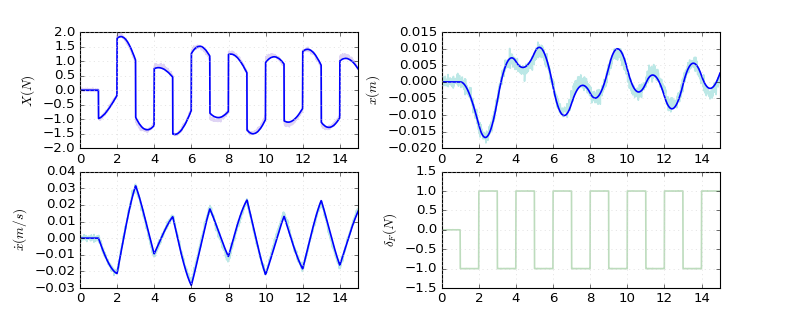

In [13]:
fig, Axes, Lines, Text = plot(msd_est.name, T, E, Z, G, Xe=Xe, Fe=Fe)

Nice. Ok, now let's increase the amount of noise in the state & state rate by a factor of 5.

In [14]:
# Observation and state noise standard deviations
NOISE_SD = [ 0.005 for _ in range(3) ]

In [15]:
%run -i sim.py

And perform a Least-Squares estimation again. The script below does exactly the same as above.

In [16]:
%run -i reg.py

LINEAR REGRESSION:
            TRUE       EST    95% CONF
k    :   -50.0000   -25.1409 +/-2.1565
b    :   -10.0000    -7.2012 +/-1.1670
d    :     1.0000     1.0512 +/-0.0173
R^2 = 0.9300


Whoa! That's terrible! How does the estimated system response look?

<IPython.core.display.Javascript object>


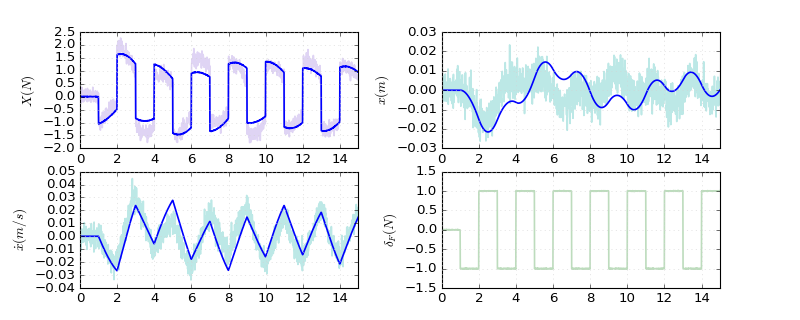

In [17]:
fig, Axes, Lines, Text = plot(msd_est.name, T, E, Z, G, Xe=Xe, Fe=Fe)

That is not good! This is primarily due to the fact that the error in the independant variables is introducing bias into the LS estimate.

Let's see how the same model compares with a different response dataset.

In [18]:
C_LS0 = C_LS

In [19]:
# Create the predefined external force vector
T_S1 = np.hstack((t0, np.arange(t0 + 1.5, tN + 1.5, 1.5), tN))
D_S1 = np.hstack((d0, np.array([ d0 + np.random.randint(-2, 3)/2.0*(1.0 - np.abs(d0)) for _ in range(T_S1.shape[0] - 2) ]), d0))
interpfun = interpolate.interp1d(T_S1, D_S1, kind='zero', axis=0, bounds_error=False)
D1 = np.array([ [ interpfun(t) ] for t in T ])
T_S = T_S1.copy()
D_S = D_S1.copy()
D = D1.copy()

In [20]:
%run -i sim.py

Now we'll use the new external force input to stimulate our model.

In [21]:
msd_est.set_external_forces(T, E, 'linear_uniform')

for i in range(len(c_idx)):
    msd_est.set_coeffs({ 'k': C_LS0[0], 'b': C_LS0[1], 'd': C_LS0[2] })

# Compute the response
Xe, Xedot, Fe = msd_est.integrate(z0, T)

And plot the system response.

<IPython.core.display.Javascript object>


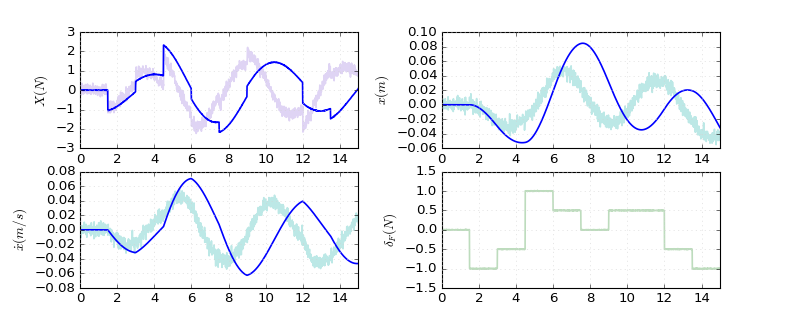

In [22]:
fig, Axes, Lines, Text = plot(msd.name, T, E, Z, G, Xe=Xe, Fe=Fe)

This really highlights the deficiency of the equation error (least squares) approach.

### Nonlinear (iterative) Gradient-based Estimation

Let's try that again, this time using an iterative technique. We'll use Powell's Method here.

Going back to our original external force vector:

In [23]:
# Create the predefined external force vector
T_S = T_S0.copy()
D_S = D_S0.copy()
D = D0.copy()

In [24]:
%run -i sim.py

Create the objective function and minimise.

In [25]:
import math
import time

from scipy import optimize
from plot import updateplot

<IPython.core.display.Javascript object>


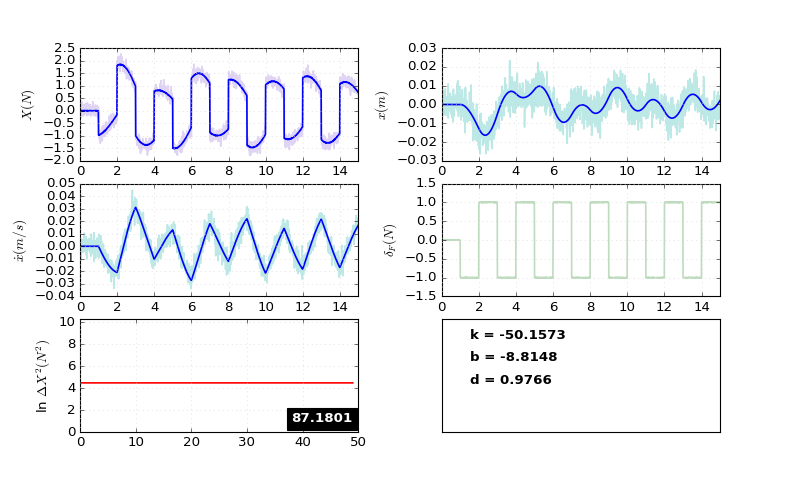

POWELL'S MINIMIZATION:
Optimization terminated successfully.
         Current function value: 87.147933
         Iterations: 7
         Function evaluations: 616
Time elapsed: 78.649754 seconds

            TRUE      F_EST
k    :   -50.0000   -50.1573
b    :   -10.0000    -8.8148
d    :     1.0000     0.9766


In [26]:
FF = ml.repmat(None, 50, 1)

msd_fest = MSD_CYTHON("Mass-Spring-Damper_FMIN_EST (Cython)")
msd_fest.set_external_forces(T, E, 'linear_uniform')

fig, Axes, Lines, Text = plot(msd_fest.name, T, E, Z, G, Xe=np.zeros(X.shape), Fe=np.zeros(F.shape), FF=FF)
fig.canvas.draw()

kws = { 'fig': fig, 'Axes': Axes, 'Lines': Lines, 'Text': Text }

c_idx = ['k', 'b', 'd']

print "POWELL'S MINIMIZATION:"

class Objfun(object):

    def __init__(self, z0, T, G, FF):
        self.z0 = z0
        self.T = T
        self.G = G
        self.FF = FF
        self.fopt_max = None
        self.it = 0;

    def __call__(self, C, fig, Axes, Lines, Text):
        msd_fest.set_coeffs({ 'k': C[0], 'b': C[1], 'd': C[2] })

        # Compute the response
        Xe, Xedot, Fe = msd_fest.integrate(self.z0, self.T)

        # For fmin, fmin_powell, fmin_bfgs, fmin_l_bfgs_b
        dF = G - Fe
        fopt_sum = np.sum(dF*dF)

        if (self.it < np.size(FF, 0)):
            self.FF[self.it, 0] = math.log(fopt_sum)
        else:
            self.FF = np.roll(self.FF, -1)
            self.FF[-1, 0] = math.log(fopt_sum)

        f_max = None
        if ((self.fopt_max is None) or (self.fopt_max < math.log(fopt_sum))):
            f_max = math.log(fopt_sum) * 1.1
            self.fopt_max = math.log(fopt_sum)
            # rescale = True
        f_txt = '{:.4f}'.format(fopt_sum)

        updateplot(fig, Axes, Lines, Text, Xe, Fe, self.FF, f_max=f_max, f_txt=f_txt, c_txt=C)

        self.it += 1

        return fopt_sum

tic = time.clock()

objfun = Objfun(z0, T, G, FF)

# Need to start with a nontrivial parameter set to avoid getting stuck in a local minima straight away...
C = optimize.fmin_powell(objfun, C0, args=( fig, Axes, Lines, Text ), maxiter=100)

toc = time.clock() - tic
print "Time elapsed: {:f} seconds".format(toc)

C_PM = C.tolist()

print
print "            TRUE      F_EST"
for i in range(len(c_idx)):
    ck = c_idx[i]
    print "{:5s}: {:10.4f} {:10.4f}".format(ck, msd.get_coeffs()[ck], C_PM[i])

msd_fest.set_coeffs({ 'k': C_PM[0], 'b': C_PM[1], 'd': C_PM[2] })

# Compute the response
Xe, Xedot, Fe = msd_fest.integrate(z0, T)

Much better! Although it did take some time. And the system response is quite good too. Let's check again using a different input and response dataset.

In [27]:
C_PM0 = C_PM

In [28]:
T_S = T_S1.copy()
D_S = D_S1.copy()
D = D1.copy()

In [29]:
%run -i sim.py

In [30]:
msd_est.set_external_forces(T, E, 'linear_uniform')

for i in range(len(c_idx)):
    msd_est.set_coeffs({ 'k': C_PM0[0], 'b': C_PM0[1], 'd': C_PM0[2] })

# Compute the response
Xe, Xedot, Fe = msd_est.integrate(z0, T)

<IPython.core.display.Javascript object>


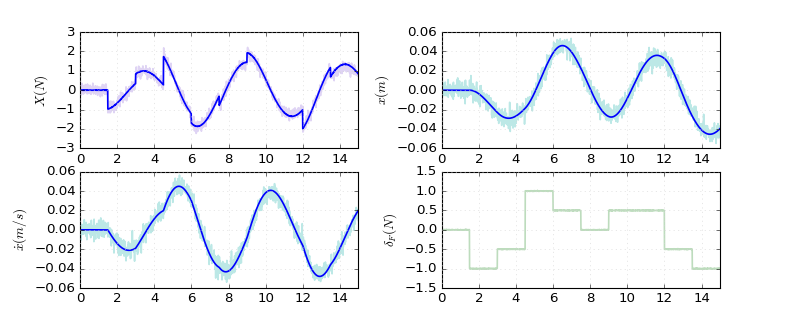

In [31]:
fig, Axes, Lines, Text = plot(msd_fest.name, T, E, Z, G, Xe=Xe, Fe=Fe)

Yes, that's much better. Other methods (from the SciPy Optimisation Library) that work just as well include BFGS, and nonlinear Least-Squares.

Let's see how a Levenberg-Marquardt optimisation performs. Using our original external force vector.

In [32]:
# Create the predefined external force vector
T_S = T_S0.copy()
D_S = D_S0.copy()
D = D0.copy()

In [33]:
%run -i sim.py

In [34]:
import lmfit as lm

<IPython.core.display.Javascript object>


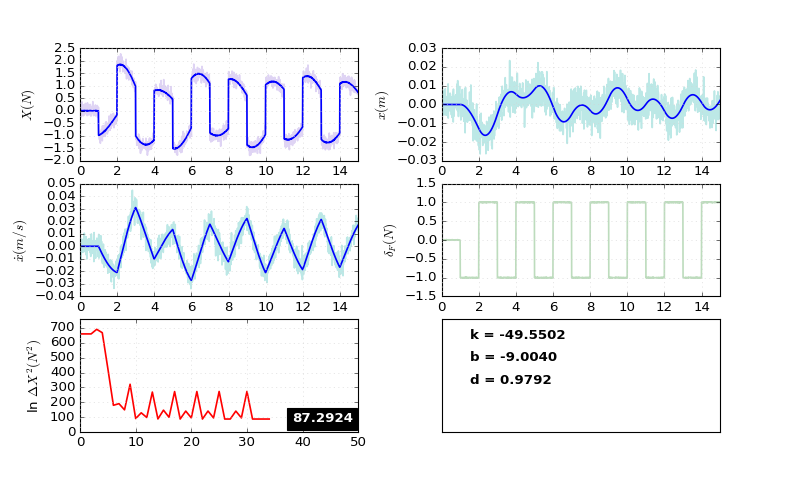

LEVENBERG-MARQUARDT OPTIMIZATION:
Time elapsed: 5.075054 seconds

            TRUE      F_EST
k    :   -50.0000   -49.5502
b    :   -10.0000    -9.0040
d    :     1.0000     0.9792


In [35]:
FF = ml.repmat(None, 50, 1)

msd_fest = MSD_CYTHON("Mass-Spring-Damper_FMIN_EST (Cython)")
msd_fest.set_external_forces(T, E, 'linear_uniform')

fig, Axes, Lines, Text = plot(msd_fest.name, T, E, Z, G, Xe=np.zeros(X.shape), Fe=np.zeros(F.shape), FF=FF)
fig.canvas.draw()

kws = { 'fig': fig, 'Axes': Axes, 'Lines': Lines, 'Text': Text }

c_idx = ['k', 'b', 'd']

print "LEVENBERG-MARQUARDT OPTIMIZATION:"

class Fcn2min(object):

    def __init__(self, z0, T, G, FF):
        self.z0 = z0
        self.T = T
        self.G = G
        self.FF = FF
        self.fopt_max = None
        self.it = 0;

    def __call__(self, P, **kws):
        C = [ P[c_idx[i]].value for i in range(len(c_idx)) ]
        msd_fest.set_coeffs({ 'k': C[0], 'b': C[1], 'd': C[2] })

        # Compute the response
        Xe, Xedot, Fe = msd_fest.integrate(self.z0, self.T)

        fopt = np.ravel(self.G - Fe)
        fopt_sum = np.sum(fopt*fopt)

        if (self.it < np.size(FF, 0)):
            self.FF[self.it, 0] = fopt_sum
        else:
            self.FF = np.roll(self.FF, -1)
            self.FF[-1, 0] = fopt_sum

        f_max = None
        if ((self.fopt_max is None) or (self.fopt_max < fopt_sum)):
            f_max = fopt_sum * 1.1
            self.fopt_max = fopt_sum
        f_txt = '{:.4f}'.format(fopt_sum)

        updateplot(kws['fig'], kws['Axes'], kws['Lines'], kws['Text'], Xe, Fe, self.FF, f_max=f_max, f_txt=f_txt, c_txt=C)

        self.it += 1

        return fopt

# Create a set of Parameters
P = lm.Parameters()
for i in range(len(c_idx)):
    ck = c_idx[i]
    P.add(ck, value=C0[i])

tic = time.clock()

fcn2min = Fcn2min(z0, T, G, FF)

# Do fit, here with leastsq model
res = lm.minimize(fcn2min, P, kws=kws, method='leastsq', epsfcn=0.1)

toc = time.clock() - tic
print "Time elapsed: {:f} seconds".format(toc)

C_LM = [ res.params[c_idx[i]].value for i in range(len(c_idx)) ]

print
print "            TRUE      F_EST"
for i in range(len(c_idx)):
    ck = c_idx[i]
    print "{:5s}: {:10.4f} {:10.4f}".format(ck, msd.get_coeffs()[ck], C_LM[i])

msd_fest.set_coeffs({ 'k': C_LM[0], 'b': C_LM[1], 'd': C_LM[2] })

# Compute the response
Xe, Xedot, Fe = msd_fest.integrate(z0, T)

Getting close... and a lot faster!

Last, we're going to try to fit our model using Markov-Chain Monte Carlo (MCMC).

In [36]:
import pymc as mc

Build the model and run the sampler.

BUILDING PROBABILITY DISTRIBUTION MODEL



<IPython.core.display.Javascript object>


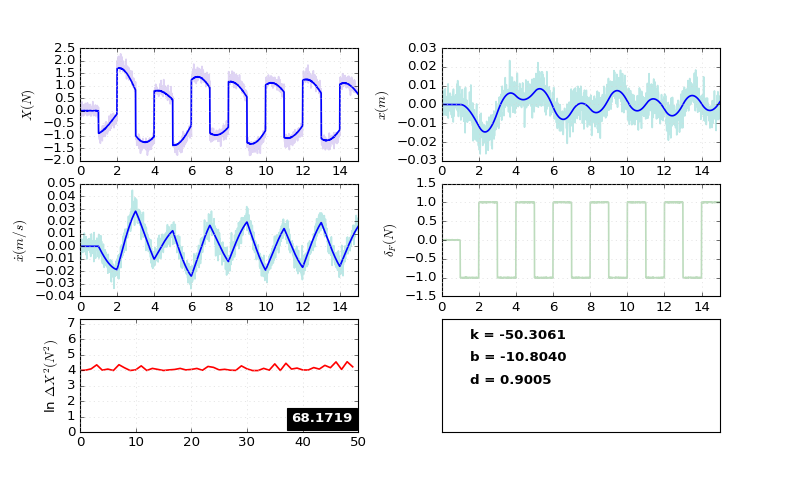

BAYES ESTIMATE (MARKOV CHAIN MONTE CARLO):

Chain 0:
 [-----------------100%-----------------] 200 of 200 complete in 29.3 sec
Chain 1:
 [-----------------100%-----------------] 500 of 500 complete in 76.5 sec
Time elapsed: 00h 01m 45s
            TRUE      B_EST
k    :   -50.0000   -49.5842
b    :   -10.0000   -10.5833
d    :     1.0000     1.0136


In [37]:
# Number of samples for chain-0 (initial estimation) and chain-1 (training)
Nc = [ 200, 500 ]

# Zero the RNG seed
np.random.seed(1)

print "BUILDING PROBABILITY DISTRIBUTION MODEL"

c_idx = [ 'k', 'b', 'd' ]

FF = ml.repmat(None, 50, 1)

print

fig, Axes, Lines, Text = plot(msd.name, T, E, Z, G, Xe=np.zeros(X.shape), Fe=np.zeros(F.shape), FF=FF)

kws = { 'fig': fig, 'Axes': Axes, 'Lines': Lines, 'Text': Text }

# Create the model (Cython extension)
msd_best = MSD_CYTHON("Mass-Spring-Damper_BAYES_EST (Cython)")
msd_best.set_external_forces(T, E, 'linear_uniform')

# Setup the stochastic model
sdnu_0 = sdnu
sdnu_L = [ 0.0, sdnu_0*2.0 ]

# Intermediate parameter dict
CD = { ck : None for ck in c_idx }

# Limits for uniform priors
CL = [ [ 0, 0 ] for ck in c_idx ]
for i in range(len(c_idx)):
    ck = c_idx[i]
    if (np.abs(C0[i]) < 0.1):
        cl = C0[i] - 1.0
        cu = C0[i] + 1.0
    else:
        cl = C0[i] - 2.0*np.abs(CT[i])
        cu = C0[i] + 2.0*np.abs(CT[i])
    CL[i] = [ cl, cu ]

# Stochastic variable dict
P = { }
for i in range(len(c_idx)):
    ck = c_idx[i]
    P[ck] = mc.Uniform(ck, lower=CL[i][0], upper=CL[i][1], value=C0[i])

class Meanfcn(object):

    def __init__(self, z0, T, G, kws, FF, CD, C0):
        self.z0 = z0
        self.T = T
        self.G = G
        self.kws = kws
        self.FF = FF
        self.fopt_max = None
        self.it = 0;
        self.CD = CD
        self.C0 = C0
        self.C = C0

    def __call__(self, **kwargs):
        for i in range(len(c_idx)):
            ck = c_idx[i]
            self.CD[ck] = self.C0[i]

        for ck in kwargs.keys():
            self.CD[ck] = kwargs[ck].item()
            i = c_idx.index(ck)
            self.C[i] = kwargs[ck].item()

        msd_best.set_coeffs(self.CD)

        # Compute the response
        Xe, Xedot, Fe = msd_best.integrate(z0, T)

        dF = F - Fe
        fopt_sum = np.sum(dF*dF)

        if (self.it < np.size(FF, 0)):
            self.FF[self.it, 0] = math.log(fopt_sum)
        else:
            self.FF = np.roll(self.FF, -1)
            self.FF[-1, 0] = math.log(fopt_sum)

        f_max = None
        if ((self.fopt_max is None) or (self.fopt_max < math.log(fopt_sum))):
            f_max = math.log(fopt_sum) * 1.1
            self.fopt_max = math.log(fopt_sum)
        f_txt = '{:.4f}'.format(fopt_sum)

        updateplot(self.kws['fig'], self.kws['Axes'], self.kws['Lines'], self.kws['Text'], Xe, Fe, self.FF, f_max=f_max, f_txt=f_txt, c_txt=self.C)

        self.it += 1

        return Xe[:,1]

def eval_prec(**kwargs):
    std = kwargs.values()[0]
    return 1.0/std**2.0

meanfcn = Meanfcn(z0, T, G, kws, FF, CD, C0)

pk = { ck: P[ck] for ck in c_idx } # parents
mean_nu = mc.Deterministic(meanfcn, "Deterministic mean function", 'mean', pk, dtype=np.float64, trace=True, cache_depth=2, plot=False, verbose=0)
std_nu = mc.Uniform('std', lower=sdnu_L[0], upper=sdnu_L[1], value=sdnu_0)
pk = { 'std': std_nu } # parents
prec_nu = mc.Deterministic(eval_prec, "Deterministic precision", 'prec', pk, dtype=np.float64, trace=True, cache_depth=2, plot=False, verbose=0)
obs_nu = mc.Normal('obs', mean_nu, prec_nu, value=Nu, observed=True)

P['obs'] = obs_nu

model = mc.Model(P)

stoch_list = list(c_idx)
stoch_list.append('std')

# Stochastic model setup complete

print "BAYES ESTIMATE (MARKOV CHAIN MONTE CARLO):"

Nccs = [ 0 ] + Nc
for k in range(1, len(Nccs)):
    Nccs[k] += Nccs[k - 1]
mcmc_trace_idx = [ range(Nccs[k], Nccs[k + 1]) for k in range(len(Nc)) ]

mcmc_stats_alpha = 0.05
mcmc_stats_conf = int((1.0 - mcmc_stats_alpha)*100.0)
mcmc_stats_hpd_key = '%d%% HPD interval' % mcmc_stats_conf
mcmc_stats_batches = 100
mcmc_stats_quantiles = ( 2.5, 25, 50, 75, 97.5 )

# We use RAM for database storage
mcmc = mc.MCMC(model)

mcmc.use_step_method(mc.AdaptiveMetropolis, [ P[ck] for ck in c_idx ])

tic = time.time()

for k in range(len(Nc)):
    print
    print "Chain {:d}:".format(k)
    mcmc.sample(Nc[k], burn=0, thin=1, tune_interval=1000, save_interval=None, progress_bar=True)

mcmc_stats = [ mcmc.stats(chain=k) for k in range(len(Nc)) ]
mcmc_trace = [ { ck : np.ravel(mcmc.trace(ck, chain=k)[:]) for ck in stoch_list } for k in range(len(Nc)) ]
mcmc_deviance = [ mcmc.trace('deviance', chain=k)[:] for k in range(len(Nc)) ]

# Update Nc if sampling halted prematurely
Nc = [ len(mcmc_trace[k][stoch_list[0]]) for k in range(len(Nc)) ]
Nccs = [ 0 ] + Nc
for k in range(1, len(Nccs)):
    Nccs[k] += Nccs[k - 1]
mcmc_trace_idx = [ range(Nccs[k], Nccs[k + 1]) for k in range(len(Nc)) ]

mcmc_trace_all = { ck : np.hstack((mcmc_trace[k][ck] for k in range(len(Nc)))) for ck in stoch_list }

print

toc = time.time() - tic
print time.strftime("Time elapsed: %Hh %Mm %Ss", time.gmtime(toc))

A_mcmc = np.vstack(( mcmc_trace[-1][ck] for ck in c_idx ))
Cove_mcmc = np.cov(A_mcmc)
if np.all(np.diag(Cove_mcmc) > 0.0):
    Vare_mcmc = np.sqrt(np.diag(Cove_mcmc))
    Corre_mcmc = ((Cove_mcmc.T/Vare_mcmc).T)/Vare_mcmc

C_MC = [ None for i in range(len(c_idx)) ]
Ce_MC = [ None for i in range(len(c_idx)) ]

for i in range(len(c_idx)):
    ck = c_idx[i]
    C_MC[i] = np.mean(mcmc_trace[-1][ck])
    Ce_MC[i] = np.sqrt(np.cov(mcmc_trace[-1][ck]))

print "            TRUE      B_EST"
for i in range(len(c_idx)):
    ck = c_idx[i]
    print "{:5s}: {:10.4f} {:10.4f}".format(ck, msd.get_coeffs()[ck], C_MC[i])

msd_best.set_coeffs({ 'k': C_MC[0], 'b': C_MC[1], 'd': C_MC[2] })

# Compute the response
Xe, Xedot, Fe = msd_best.integrate(z0, T)

Very good! Let's look in a little more detail as to how the algorithm performed. To do that, we can plot the traces, autocorrelation and posterior distributions for each of the coefficients.

In [38]:
import matplotlib.pylab as pl
from pymc.utils import quantiles as calc_quantiles, hpd as calc_hpd

<IPython.core.display.Javascript object>


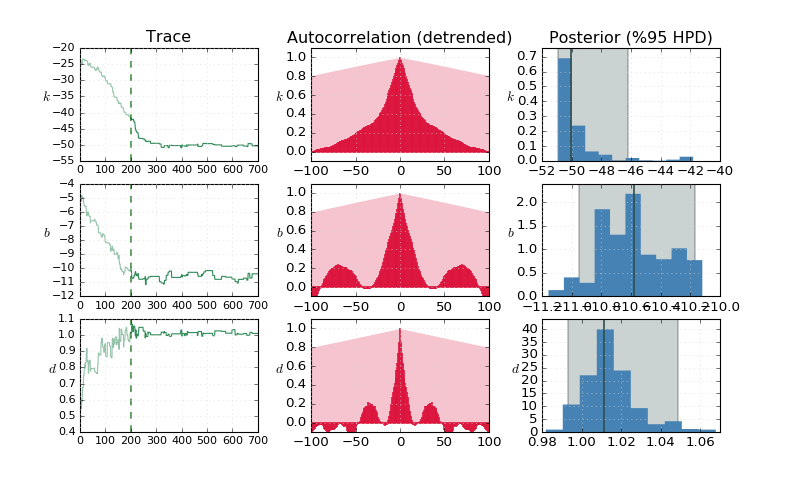

In [39]:
C_str = { 'k' : r'$k$', 'b' : r'$b$', 'd' : r'$d$' }

nc = 3 # number of columns
nr = len(c_idx) # number of rows

figname = msd_best.name + " Coefficient Traces, Autocorrelations & Histograms"

fig, AxesArr = pp.subplots(nr, nc, figsize=(10.0, 6.0))

acorr_maxlags = 100
hist_num_bins = min(50, max(10, Nc[-1]/250))
hist_hpd_alpha = 0.05

Nccs = [ 0 ] + Nc
for k in range(1, len(Nccs)):
    Nccs[k] += Nccs[k - 1]

for i in range(nr):
    ck = c_idx[i]

    assert (len(mcmc_trace[-1][ck]) == Nc[-1]), "Trace length for %s (%d) is not equal to %d!" % (ck, len(mcmc_trace[-1][ck]), Nc[-1])

    c = np.mean(mcmc_trace[-1][ck])

    ax = AxesArr[i, 0]
    ax.grid(color='lightgrey', linestyle=':')
    ax.tick_params(axis='both', which='major', labelsize=10)
    for k in range(len(Nc)):
        alpha = 0.5
        if (k == len(Nc) - 1):
            alpha = 1.0
        ax.plot(range(Nccs[k], Nccs[k + 1]), mcmc_trace[k][ck], alpha=alpha, color='seagreen', linestyle='-', linewidth=1.0, zorder=2)
        if (k > 0):
            ax.axvline(Nccs[k], alpha=0.75, linestyle='--', linewidth=1.5, color='darkgreen')
    ax.set_xlim(0, sum(Nc))
    ax.set_ylabel(C_str[ck], rotation='horizontal')
    if (i == 0):
        ax.set_title("Trace")

    ax = AxesArr[i, 1]
    ax.grid(color='lightgrey', linestyle=':')
    # Calculate the autocorrelation (raw and detrended)
    (acorr_lags, acorr_c, acorr_line, acorr_b) = ax.acorr(mcmc_trace[-1][ck], detrend=pl.mlab.detrend_none, linewidth=0.0, markersize=0.0, maxlags=acorr_maxlags, usevlines=False)
    ax.fill_between(acorr_lags, acorr_line.get_ydata(), alpha=0.25, color='crimson', linewidth=0.0)
    ax.acorr(mcmc_trace[-1][ck], color='crimson', detrend=pl.mlab.detrend_mean, linestyle='-', linewidth=1.5, maxlags=acorr_maxlags)
    ax.set_xlim(-acorr_maxlags, acorr_maxlags)
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel(C_str[ck], rotation='horizontal')
    if (i == 0):
        ax.set_title("Autocorrelation (detrended)")

    ax = AxesArr[i, 2]
    ax.grid(color='lightgrey', linestyle=':')
    # Calculate the median and 95% Highest Probability Density (HPD) or minimum width Bayesian Confidence (BCI) interval
    hist_quant = calc_quantiles(mcmc_trace[-1][ck])
    hist_hpd = calc_hpd(mcmc_trace[-1][ck], hist_hpd_alpha)
    (hist_n, hist_bins, hist_patches) = ax.hist(mcmc_trace[-1][ck], bins=hist_num_bins, color='steelblue', histtype='stepfilled', linewidth=0.0, normed=True, zorder=2)
    ax.set_ylim(0.0, max(hist_n)*1.1)
    ax.axvspan(hist_hpd[0], hist_hpd[1], alpha=0.25, facecolor='darkslategray', linewidth=1.5)
    ax.axvline(hist_quant[50], linestyle='-', linewidth=1.5, color='darkslategray')
    ax.set_ylabel(C_str[ck], rotation='horizontal')
    if (i == 0):
        ax.set_title("Posterior (%%%2.0f HPD)" % ((1.0 - hist_hpd_alpha)*100.0))

pp.subplots_adjust(left=0.1, wspace=0.3)

Nice, but we can do better by starting with a more accurate initial estimate and running more samples.

In [46]:
# Number of samples for chain-0 (initial estimation) and chain-1 (training)
NUM_SAMPLES = [ 5000 ]

C0 = C_LM

In [47]:
%run -i bms.py

 BUILDING PROBABILITY DISTRIBUTION MODEL 

 BAYES ESTIMATE (MARKOV CHAIN MONTE CARLO): 

 Chain 0: 
 [-----------------100%-----------------] 5000 of 5000 complete in 63.8 sec
Time elapsed: 00h 01m 03s
            TRUE      B_EST
k    :   -50.0000   -50.2113
b    :   -10.0000   -10.4407
d    :     1.0000     1.0096


Plot the traces, autocorrelation and posterior distributions for each of the coefficients.

<IPython.core.display.Javascript object>


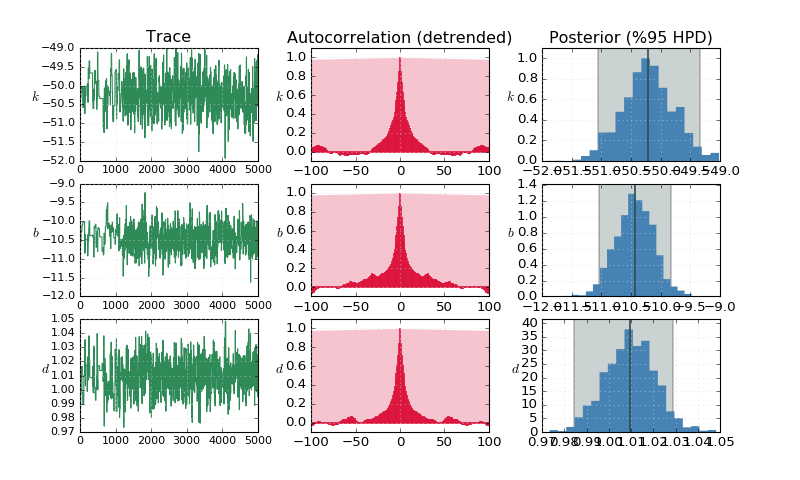

In [48]:
%run -i bmsplot.py

Excellent! With a fast, accurate optimisation initially and more samples for the adaptive phase, we can get a good estimate of the posteriors.